In [1]:
using Plots
using LinearAlgebra
using NumericalIntegration
using Distributions

In [3]:
using LaTeXStrings

# 1. Set the backend (GR is the default, fast, and handles this well)
gr()

# 2. Configure Global Settings for Retina + LaTeX Look
default(
    # Retina / High-DPI settings
    fmt = :png,         # PNG renders faster than SVG for complex plots
    dpi = 300,          # 300 DPI makes it crisp on Retina screens (standard is 72-100)
    
    # LaTeX Font settings
    fontfamily = "Computer Modern", # Use the standard LaTeX font
    guidefontsize = 12,             # Adjust font sizes for readability
    tickfontsize = 10,
    legendfontsize = 10
)

SINGLE PARTICLE DENSITY OF STATES

In [2]:
function naive_degeneracy(Emax)
    count = Dict{Float64, Int}()
    for i in 0:Emax
        for j in 0:Emax
            for k in 0:Emax
                E = i + j + k
                if E <= Emax
                    count[E] = get(count, E, 0) + 1
                end
            end
        end
    end
    return count
end

naive_degeneracy (generic function with 1 method)

In [8]:
for (E, g) in sort(collect(naive_degeneracy(20)))
    println("E = $E , N(E) = $g")
end

E = 0.0 , N(E) = 1
E = 1.0 , N(E) = 3
E = 2.0 , N(E) = 6
E = 3.0 , N(E) = 10
E = 4.0 , N(E) = 15
E = 5.0 , N(E) = 21
E = 6.0 , N(E) = 28
E = 7.0 , N(E) = 36
E = 8.0 , N(E) = 45
E = 9.0 , N(E) = 55
E = 10.0 , N(E) = 66
E = 11.0 , N(E) = 78
E = 12.0 , N(E) = 91
E = 13.0 , N(E) = 105
E = 14.0 , N(E) = 120
E = 15.0 , N(E) = 136
E = 16.0 , N(E) = 153
E = 17.0 , N(E) = 171
E = 18.0 , N(E) = 190
E = 19.0 , N(E) = 210
E = 20.0 , N(E) = 231


In [4]:
function naive_degeneracy_cube(Emax)
    nmax = floor(Int, sqrt(Emax))
    count = Dict{Float64, Int}()
    for i in -nmax:nmax
        for j in -nmax:nmax
            for k in -nmax:nmax
                E = i^2 + j^2 + k^2
                if abs(E) <= Emax
                    count[E] = get(count, E, 0) + 1
                end
            end
        end
    end
    return count
end

naive_degeneracy_cube (generic function with 1 method)

In [9]:
for (E, g) in sort(collect(naive_degeneracy_cube(20)))
    println("E = $E , N(E) = $g")
end

E = 0.0 , N(E) = 1
E = 1.0 , N(E) = 6
E = 2.0 , N(E) = 12
E = 3.0 , N(E) = 8
E = 4.0 , N(E) = 6
E = 5.0 , N(E) = 24
E = 6.0 , N(E) = 24
E = 8.0 , N(E) = 12
E = 9.0 , N(E) = 30
E = 10.0 , N(E) = 24
E = 11.0 , N(E) = 24
E = 12.0 , N(E) = 8
E = 13.0 , N(E) = 24
E = 14.0 , N(E) = 48
E = 16.0 , N(E) = 6
E = 17.0 , N(E) = 48
E = 18.0 , N(E) = 36
E = 19.0 , N(E) = 24
E = 20.0 , N(E) = 24


TRAPPED BOSONS (CANONICAL ENSEMBLE)

In [20]:
function canonic_bosons(step_integration, beta, N_particles, Emax)
    Z = 0.0
    E = 0.0
    N0 = 0.0
    degeneracy_dict = naive_degeneracy(Emax)
    for theta in -pi:step_integration:pi
        x = exp(-im * theta) 

        if abs(theta) < 1e-9
            z = float(N_particles + 1)
            n0 = float(N_particles * (N_particles + 1)) / 2.0
            e = 0.0
        else
            z = (1 - x^(N_particles + 1)) / (1 - x)
            n0 = (x - (N_particles + 1) * x^(N_particles + 1) + N_particles * x^(N_particles + 2)) / (1 - x)^2
            e = 0.0
        end
        for p in 1:Emax
            number = get(degeneracy_dict, Float64(p), 0)
            z *= (1 - exp(-beta*p)*exp(im*theta))^(-number)
            e += number * p * exp(-beta*p) * exp(im*theta)/ (1 - exp(-beta*p) * exp(im*theta))
        end
        n0 = -(N_particles+1)*exp(im*theta*(N_particles+1))/(1 - exp(im*theta*(N_particles+1))) + exp(im*theta)/(1 - exp(im*theta))
        Z += z * exp(-im*theta*N_particles)/ (2*pi)
        E += e * z * exp(-im*theta*N_particles)/ (2*pi)
        N0 += n0 * z * exp(-im*theta*N_particles)/ (2*pi)
    end
    E /= Z
    N0 /= Z
    return E, Z, N0
end

canonic_bosons (generic function with 1 method)

In [34]:
T_list = collect(0.01:0.1:1.0)
beta_list = 1 ./ T_list
E_list = Float64[]
N0_list = Float64[]
for beta in beta_list
    E, Z, N0 = canonic_bosons(0.01, beta, 10, 20)
    push!(E_list, real(E))
    push!(N0_list, real(N0)/10)
end
reverse!(T_list)

10-element Vector{Float64}:
 0.91
 0.81
 0.71
 0.61
 0.51
 0.41
 0.31
 0.21
 0.11
 0.01

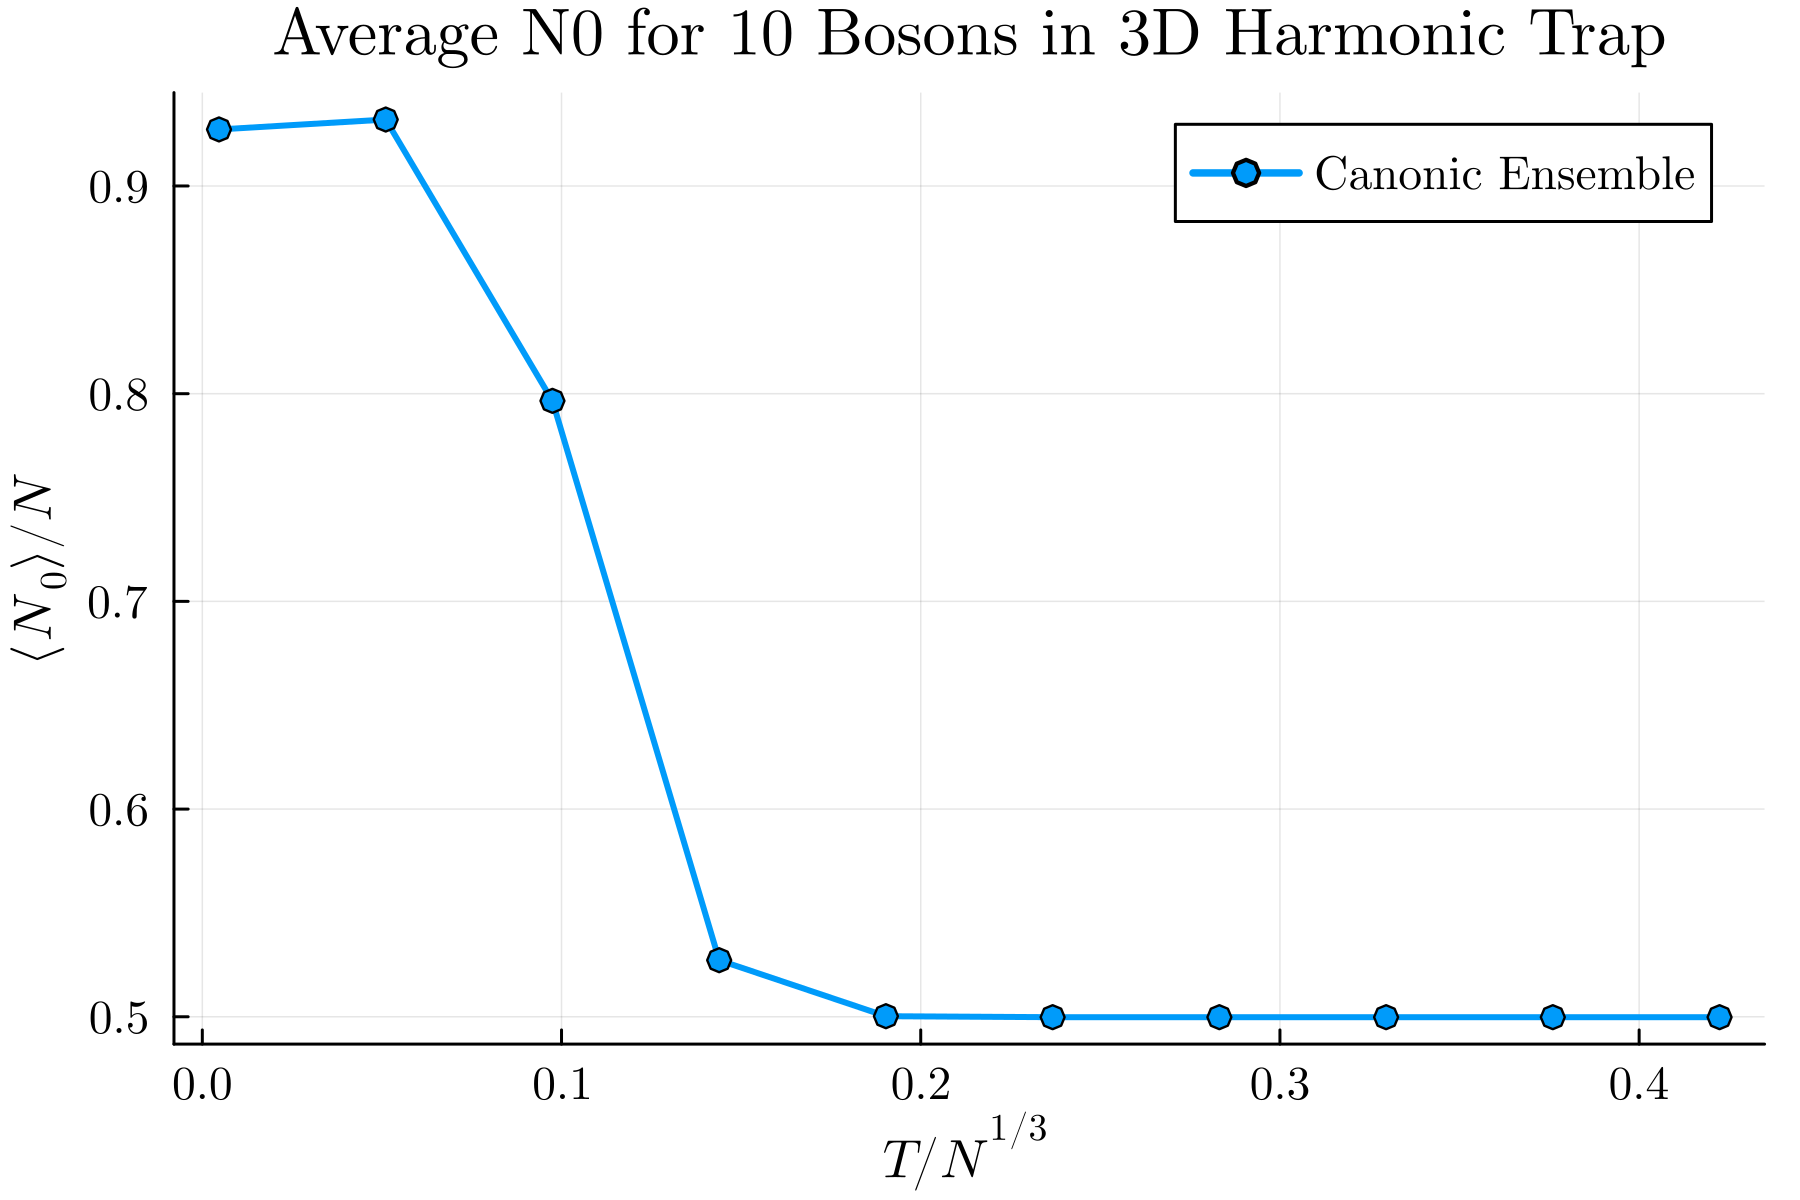

In [37]:
plot()
plot(T_list/(10^(1/3)), N0_list, 
    xlabel = L"T/N^{1/3}", 
    ylabel = L"\langle N_0 \rangle/N", 
    label = "Canonic Ensemble",
    legend = :topright,
    lw = 2,
    marker = :o,
    markersize = 4,
    title = "Average N0 for 10 Bosons in 3D Harmonic Trap"
)

In [38]:
function grandcan_bosons(target_N, mu_min, cutoff, beta, Emax)
    mu_max = 0.0
    for i in 1:cutoff
        mu = (mu_min + mu_max) / 2
        p = naive_degeneracy(Emax)
        N_mean = sum( value*exp(-beta*(energy - mu)) / (1 - exp(-beta*(energy - mu))) for (energy, value) in p)
        if N_mean < target_N
            mu_min = mu
        else
            mu_max = mu
        end
    end
    return (mu_min + mu_max) / 2
end

grandcan_bosons (generic function with 1 method)

CANONICAL PARTITION FUNCTION OF IDEAL BOSONS

In [ ]:
function ZK(k, beta)
    return (1-exp(-beta*k))^(-3)
end

Z (generic function with 1 method)

In [41]:
function canonic_recursion(beta, N)
    z_vals = [ZK(k, beta) for k in 1:N]
    Z_list = zeros(Float64, N + 1)
    Z_list[1] = 1.0  

    for k in 1:N
        S = 0.0
        for j in 1:k
            S += z_vals[j] * Z_list[k - j + 1]
        end
        Z_list[k + 1] = S / k
    end
    
    return Z_list[N + 1]
end

canonic_recursion (generic function with 1 method)

In [42]:
function canonic_recursion_patch(beta)
    z_vals = [ZK(k, beta) for k in 1:N]
    y_vals = [ZK(k, beta) for k in 1:N]
    Z_list = zeros(Float64, N + 1)
    Y_list = zeros(Float64, N + 1)
    Z_list[1] = 1.0  
    Y_list[1] = 1.0
    for k in 1:N
        S = 0.0
        C = 0.0
        for j in 1:k
            S += z_vals[j] * Z_list[k - j + 1]
            C += z_vals[j] * Y_list[k - j + 1] + y_vals[j] * Z_list[k - j + 1]
        end
        Z_list[k + 1] = S / k
        Y_list[k + 1] = C / k
    end
    E = - Y_list[N + 1] / Z_list[N + 1]
    N0 = sum(Z_list[k] for k in 1:N) / Z_list[N + 1] #warning E0 has to be 0
    return Z_list, E, N0
end

canonic_recursion_patch (generic function with 1 method)

In [43]:
function tower_sample(pi_list)
    n = length(pi_list)
    @assert n>0 "Number of levels must be greater than zero"
    Pi = zeros(Float64, n)
    for j in 2:n
        Pi[j] = Pi[j-1] + pi_list[j]
    end
    dist = Normal(0.0, Pi[end])
    k = searchsortedfirst(Pi, rand(dist)) #warning: the Pi list must be sorted (pi_list is non-negative list numbers ?) 
    return k
end

tower_sample (generic function with 1 method)

DIRECT SAMPLING ALGORITHM FOR IDEAL BOSONS

In [44]:
function direct_cycles(z_list, Z_list)
    N = length(z_list)
    m_list = zeros(Int, length(z_list))
    M = N
    rev_Z = reverse!(Z_list)
    while M>0
        k = tower_sample(z_list[start:M] .* rev_Z[start:M])
        M -= k
        m_list[k] += 1
    end
    return m_list
end

direct_cycles (generic function with 1 method)

In [45]:
function direct_harmonic_bosons(z_list, Z_list)
    m_list = direct_cycles(z_list, Z_list)
    l = 0 
    path = zeros(Float64, sum(m_list))
    for (k, value) in enumerate(m_list)
        if value != 0
            for j in 1:value
                gamma = randn()
                path[l:l+k] = levy_harmonic_path(gamma, gamma, k, k*beta)
                l += k
            end
        end
    end
    return path 
end

direct_harmonic_bosons (generic function with 1 method)

refaire figure 4.23, 4.26 ?